# Advanced Lane Lines Project

Florin Gheorghe  
27.03 - 05.04.2018       

The steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The best way to benefit from a project is to break it in steps and work on it every day; try to solve one step per day; forgeting and remembering about the project helps in imprinting the project in memory for a longer time.

## 0. Importing packages

In [1]:
# import packages
# numerical
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# computer vision
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed

# system
import glob
import time

# to show in a separate window use qt
# to show in line with the notebook, use inline
%matplotlib inline

## 1. Compute Camera Calibration Matrix and Distortion Coefficients

The images have 9x6 corners.

In [ ]:
# read in and make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

In [ ]:
# map the coordinates of the corners in the image to the coordinates of the chessboard
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# initialize with zeros on z coordinate
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

In [ ]:
# collect all image points (corners) and object points for each image
for fname in images:
    # read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if corners are found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

In [ ]:
# computing camera matric and distortion coefficients
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)

In [ ]:
# Visualize camera matrix
print(mtx)

In [ ]:
# Visualize distortion coefficients
# [k1 k2 p1 p2 k3]
print(dist)

## 2. Apply Distortion Correction to Video

In [ ]:
# load a test image
img = mpimg.imread('./test_images/test6.jpg')

# undistort the test image using the camera matrix and distortion coefficients
dest = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dest)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
# setting up undistort function using the above parameters;
# this will be applied frame wise to unditort the video
def undistort_frame(img, mtx=mtx, dist=dist):
    # undistort
    img = cv2.undistort(img, mtx, dist, None, mtx)
    return img

In [ ]:
# read in the project video as input
input_clip = VideoFileClip('./project_video.mp4')

# initialize the output video, the video to be saved
output_clip = 'project_video_undist.mp4'

# undistort each frame using a lambda function
new_clip = input_clip.fl_image(undistort_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

## 3. Use Gradients and Color Spaces to Create a Thresholded Video

The objective is to create a video that will show very robust lane lines for all frames in the video.

In [19]:
# create a function to threshold each frame
def saturation_frame(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    Sat = hls[:,:,2]
    
    maskSat = (Sat < 100)
    Sat[maskSat] = 0 
    
    output = np.zeros((Sat.shape[0], Sat.shape[1], 3), 'uint8')
    output[..., 0] = Sat
    output[..., 1] = Sat
    output[..., 2] = Sat

    return output

In [20]:
# create a function that filters out small values and returns 255 for all other pixels
def filter_frame(img):
    masked = np.zeros_like(img)
    mask = img > 10
    masked[mask] = 255
    return masked    

In [ ]:
# read in the project video
input_clip = VideoFileClip('./project_video_transf.mp4')

# initialize the output video
output_clip = 'project_video_sat.mp4'

# apply a complex thresholding function to extract lane lines
new_clip = input_clip.fl_image(saturation_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

In [ ]:
# read in the project video
input_clip = VideoFileClip('./project_video_sat.mp4')

# initialize the output video
output_clip = 'project_video_filter.mp4'

# apply a complex thresholding function to extract lane lines
new_clip = input_clip.fl_image(filter_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

## 4. Apply a Perspective Transform on Thresholded Video

In [ ]:
# create a perspectiev tranform using a test image
img = mpimg.imread('./test_images/straight_lines1.jpg')
%matplotlib inline
# source image points;
plt.imshow(img)
plt.plot(575, 464, 'o') # top left
plt.plot(707, 464, 'o') # top right
plt.plot(258, 682, 'o') # bottom left
plt.plot(1049, 682, 'o') # bottom right

In [ ]:
# create a function to tranform the perspective on each frame
def transform_frame(img):
    # define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinates
    src = np.float32([[(575, 464), (707, 464), (258, 682), (1049, 682)]])
    
    # Four desired coordinates
    dst = np.float32([[(450, 0), (830, 0), (450, 720), (830, 720)]])
    
    # Compute the perspective tranform M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Could compute the inverse also by swapping the input parameters
    Minv= cv2.getPerspectiveTransform(dst, src)
    
    # Create the warped image using the tranformation M
    warped = cv2.warpPerspective(img, M, img_size, flags = cv2.INTER_LINEAR)
    
    return warped

In [ ]:
% matplotlib inline

# Get perspective transform
warped_img = transform_frame(img)

# Visualize undistrotion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Source image')
ax1.imshow(img)

ax2.set_title('Warped_image')
ax2.imshow(warped_img)

In [ ]:
# read in the project video
input_clip = VideoFileClip('./project_video_undist.mp4')

# initialize the output video
output_clip = 'project_video_transf.mp4'

# apply a complex thresholding function to extract lane lines
new_clip = input_clip.fl_image(transform_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

## 4.2 Processing functions to extract frames and make frames binary

In [ ]:
# create a function to save frames of a video
def save_frame(img):
    mpimg.imsave("./transf_video_frames/out"+str(int(round(time.time() * 1000)))+".jpg", img)
    return img  

In [ ]:
# save all frames in a folder
input_clip = VideoFileClip('./project_video_transf.mp4')

# initialize the output video
output_clip = 'project_video_scrap.mp4'

# apply a complex thresholding function to extract lane lines
new_clip = input_clip.fl_image(save_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

In [ ]:
# create a function that filters out small values and returns a binary image
def binary_frame(img):
    masked = np.zeros_like(img)
    mask = img > 0
    masked[mask] = 1
    return masked    

In [ ]:
# read in the project video
input_clip = VideoFileClip('./project_video_transf.mp4')

# initialize the output video
output_clip = 'project_video_transf_bin.mp4'

# apply a complex thresholding function to extract lane lines
new_clip = input_clip.fl_image(binary_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

## 5. Locate the Lane Lines and Fit a Polynomial

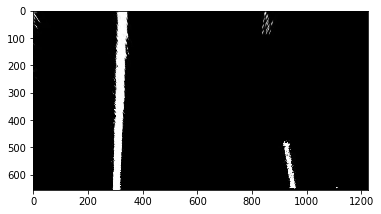

In [3]:
# create a binary image to work on
img = mpimg.imread("./test_images/test10.jpg")
plt.imshow(img)

In [4]:
binary_warped = img[:,:,0]/255.0

In [5]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [6]:
# Choose the number of sliding windows
nwindows = 10
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

In [7]:
def find_fit_frame(frame):
    #sat = saturation_frame(frame)
    #binary_warped = filter_frame(sat) #frame[:,:,0]/255.0
    binary_warped = frame[:,:,0]/255.0
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    for y in ploty:
        left_fitx = int(left_fit[0]*y**2 + left_fit[1]*y + left_fit[2])
        frame[int(y),left_fitx,:] = (255,0,0)
        right_fitx = int(right_fit[0]*y**2 + right_fit[1]*y + right_fit[2])
        frame[int(y),right_fitx,:] = (255,0,0)
    
    return frame

In [8]:
# read in the project video
input_clip = VideoFileClip('./project_video_transf.mp4')

# initialize the output video
output_clip = 'project_video_find_fit.mp4'

# apply a complex thresholding function to extract lane lines
new_clip = input_clip.fl_image(find_fit_frame)

# write the modified clip in the output, counts time to write
%time new_clip.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video project_video_find_fit.mp4
[MoviePy] Writing video project_video_find_fit.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [00:37<00:00, 33.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_find_fit.mp4 

Wall time: 38.3 s


In [8]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
    good_right_inds=((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [9]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

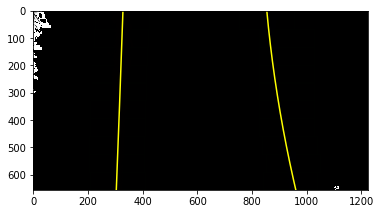

In [10]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

In [11]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

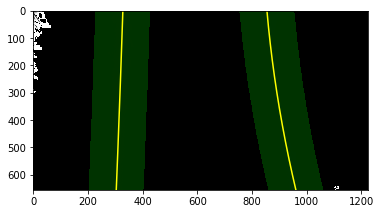

In [12]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

## 6. Determine the curvature of the lane and vehicle position with respect to center

## 7. Warp the detected lane boundaries back onto the original image

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

## 9. Creating a pipeline with the above function

In [ ]:
def pipeline(frame):

## 10. Running the pipeline against project video

## 11. Running the pipeline against challenge video